In [20]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import pickle
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
from sklearn.preprocessing import Normalizer
# from get_dataset import datasets
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression

sys.path.append("..")
sys.path.append("../analyze")
sys.path.append("../measuring_volume")
sys.path.append("../common")
import pickle
from classify_seq import make_input_seq as mis

import keras_tuner as kt

type_of_l = "L3"

TensorFlow version: 2.16.1


In [43]:
np.__version__

'1.26.4'

In [21]:
pwd

'/Users/hyakuzukamaya/Desktop/lab/SA-EDS/scripts'

## Loading a dataset

## Split into train data and test data as dataset
- データセットとして使用するデータを取得する。
- trainデータとtestデータに分割する。（例えば80%をtrainデータに、20%をtestデータに、など。）
- 書き方はデータセットとして使用するデータの type による。もし、numpy の形で持っているならhttps://www.tensorflow.org/tutorials/load_data/numpy?hl=ja が参考になります。

データセットからx, yを作成する

In [22]:
# [0, 1, ... 0] + temperature
f1 = open("../dataset/x_initial_L3.pkl", "rb")
f2 = open("../dataset/L3_data_initial.pkl", "rb")
domain_seq_dic = pickle.load(f1)
value_dic = pickle.load(f2)
domain_lst = mis.seq_lst(f"../conf/input_seq_{type_of_l}.csv")

f1.close()
f2.close()

x_data = []
y_data = []

for key in domain_seq_dic:
    print(key)
    new_x = []
    for domain in domain_lst:
        new_x.append(domain_seq_dic[key]["domain"][domain])
    new_x.append(int(key[0]))
    new_x.append(float(domain_seq_dic[key]['eigenValue_2']))
    x_data.append(new_x)
    y_data.append(value_dic[(key[0], key[1][1:])]['mean_volume'])

print(x_data)
print(y_data)



('277', '/home/user/SA-EDS/initial/L3_initial_0')
('298', '/home/user/SA-EDS/initial/L3_initial_0')
('308', '/home/user/SA-EDS/initial/L3_initial_0')
('318', '/home/user/SA-EDS/initial/L3_initial_0')
('328', '/home/user/SA-EDS/initial/L3_initial_0')
('338', '/home/user/SA-EDS/initial/L3_initial_0')
('348', '/home/user/SA-EDS/initial/L3_initial_0')
('358', '/home/user/SA-EDS/initial/L3_initial_0')
('277', '/home/user/SA-EDS/initial/L3_initial_1')
('298', '/home/user/SA-EDS/initial/L3_initial_1')
('308', '/home/user/SA-EDS/initial/L3_initial_1')
('318', '/home/user/SA-EDS/initial/L3_initial_1')
('328', '/home/user/SA-EDS/initial/L3_initial_1')
('338', '/home/user/SA-EDS/initial/L3_initial_1')
('348', '/home/user/SA-EDS/initial/L3_initial_1')
('358', '/home/user/SA-EDS/initial/L3_initial_1')
('277', '/home/user/SA-EDS/initial/L3_initial_2')
('298', '/home/user/SA-EDS/initial/L3_initial_2')
('308', '/home/user/SA-EDS/initial/L3_initial_2')
('318', '/home/user/SA-EDS/initial/L3_initial_2')


In [23]:
x_data = np.array(x_data)
y_data = np.array(y_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_train))

128
32
128
128


## Set my model
- input_shape は入力データのサイズ。
- モデルの定義方法は調べればたくさん出てきますが、例えばここ： https://sinyblog.com/deaplearning/keras_how_to/ 
- 最後の層の出力は、期待する出力データのサイズ
- [model](https://github.com/si-tm/docs-L30n/blob/master/site/ja/tutorials/quickstart/beginner.py)

In [24]:
def build_model():
    
    # model = tf.keras.models.Sequential([
    # tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dense(128, activation='relu'), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    # tf.keras.layers.Dense(1) 
    # ])

    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', name="layer1"), # units=128 : 出力空間の次元数
    tf.keras.layers.Dense(128, activation='relu', name="layer2"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer3"), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer4"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer5"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    tf.keras.layers.Dense(1) 
    ])

    optimizer = tf.keras.optimizers.Adam() # optimizers も Adam 以外に色々種類があります。調べてみてください！

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # loss 関数に何を採用するかはどんな問題を解きたいのかによります。
                                        #ここでは MSE を採用していますが、他にも色々な選択肢があります。調べてみてください！
    return model

In [25]:
model = build_model()

/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1730)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 128)            │       221,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,209 (930.50 KB)

 Trainable params: 238,209 (930.50 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
example_batch = x_train[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
# example_result

(10, 1730)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [28]:
print(example_result)

[[13.121009]
 [12.656624]
 [11.551521]
 [13.043194]
 [11.97043 ]
 [12.270079]
 [11.583403]
 [12.782248]
 [11.497406]
 [11.633713]]


In [29]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 100 # epoch 数も考慮しよう
# EPOCHS = 100 # epoch 数も考慮しよう

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,220.739059,12.671697,220.739059,318.457458,16.386244,318.457458,95
96,194.523605,12.127820,194.523605,320.577850,16.417728,320.577850,96
97,209.148376,12.523809,209.148376,314.361542,16.323092,314.361542,97
98,212.622025,12.866740,212.622025,338.212402,16.736874,338.212402,98
99,182.600952,11.418484,182.600952,369.455444,17.240738,369.455444,99


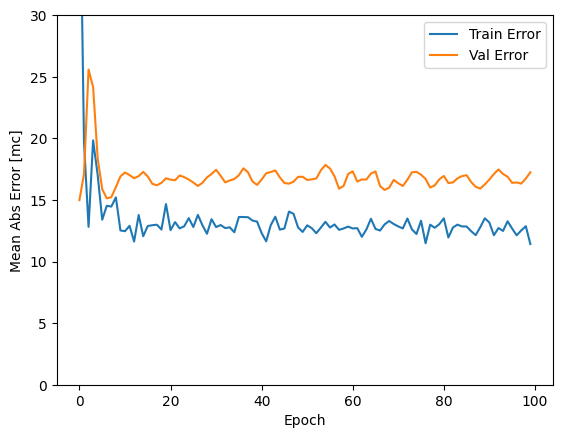

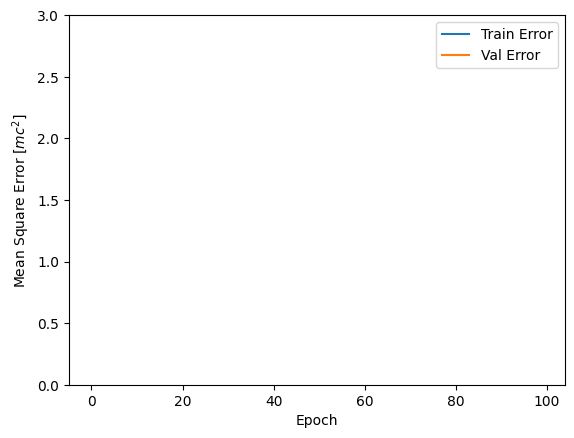

In [31]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mc]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$mc^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


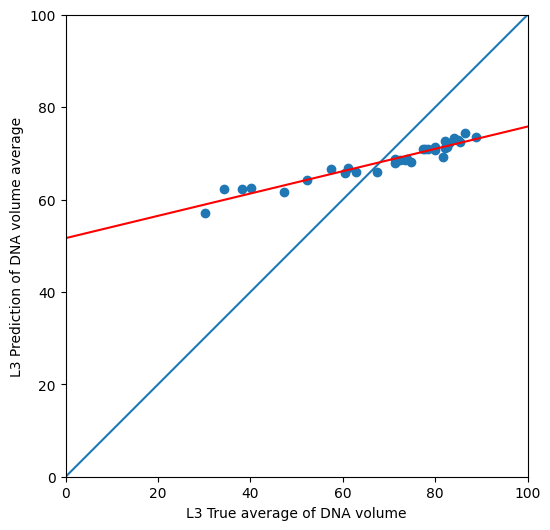

In [32]:
test_predictions = model.predict(x_test).flatten()
res = linregress(y_test, test_predictions)

plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
# plt.xlabel('True Values [mc]')
# plt.ylabel('Predictions [mc]')
plt.xlabel('L3 True average of DNA volume')
plt.ylabel('L3 Prediction of DNA volume average')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,100])
plt.ylim([0,100])
_ = plt.plot([0,100], [0,100])

plt.plot([0,100], res.intercept + res.slope*np.array([0, 100]), 'r', label='fitted line')

# normalizer 学習前

In [33]:
# トレーニングした model をどこかで使用したいなら以下のようにモデルを保存する
model.save('../saved_model/L3_initial_eigen.keras')

In [34]:
from sklearn.datasets import load_diabetes, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from tensorflow import keras 
import tensorflow as tf
import pandas as pd

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
def randomforest_regressor(x, y, x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(x_train, y_train)
    return regr.score(x_test, y_test)


# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor
def extratrees_regressor(x, y, x_train, x_test, y_train, y_test):
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, random_state=0)
    reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
    x_train, y_train)
    return reg.score(x_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def gradientboosting_regressor(X_train, X_test, y_train, y_test):
    reg = GradientBoostingRegressor(random_state=0)
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor
def stacking_regressor(X_train, X_test, y_train, y_test):
    X, y = load_diabetes(return_X_y=True)
    estimators = [
        ('lr', RidgeCV()),
        ('svr', LinearSVR(random_state=42))
    ]
    reg = StackingRegressor(
        estimators=estimators,
        final_estimator=RandomForestRegressor(n_estimators=10,
                                            random_state=42)
    )
    ref = reg.fit(X_train, y_train)
    return ref.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor
def voting_regressor(X, y, x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10, random_state=1)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    er.predict(X)
    return er.score(x_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def histgradientboosting_regressor(X, y, x_train, x_test, y_train, y_test):
    # est = HistGradientBoostingRegressor().fit(X, y)
    est = HistGradientBoostingRegressor().fit(x_train, y_train)
    return est.score(x_test, y_test)

def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

def neural_mse(x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_L3_6_model'):
    #y_data = np.concatenate([np.array(y_train),np.array(y_test)])
    #print(type(y_data), y_data.shape)
    #min_val = y_data.min()
    #max_val = y_data.max()
    #y_train = (y_train - min_val)/(max_val - min_val)
    #y_test = (y_test - min_val)/(max_val - min_val)
    #x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()
    for i in range(len(y_test)):
        print(f"Expected {y_test[i]} and got {test_predictions[i]}")

    #mse = tf.keras.losses.MeanSquaredError()
    u = ((y_test-test_predictions)**2).sum()
    v = ((y_test - y_test.mean()) ** 2).sum()

    return 1.0 - u/v #mse(y_test,test_predictions).numpy()

def new_neural_mse(x, y, x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_L3_6_model'):

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()

    mse = tf.keras.losses.MeanSquaredError()

    return mse(y_test,test_predictions).numpy()


In [36]:
x = x_data
y = y_data

extratrees = extratrees_regressor(x, y, x_train, x_test, y_train, y_test)
randomforest = randomforest_regressor(x, y, x_train, x_test, y_train, y_test) 
gradientboosting = gradientboosting_regressor(x_train, x_test, y_train, y_test)
stacking = stacking_regressor(x_train, x_test, y_train, y_test)
voting = voting_regressor(x, y, x_train, x_test, y_train, y_test)
histgradientboosting = histgradientboosting_regressor(x, y, x_train, x_test, y_train, y_test)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../saved_model/L3_initial_eigen.keras')


/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/P

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Expected 61.021353163830646 and got 66.80082702636719
Expected 62.927639947593505 and got 65.88430786132812
Expected 84.89017026578895 and got 72.98454284667969
Expected 80.03711509827546 and got 70.61627960205078
Expected 71.25612259497542 and got 68.85987854003906
Expected 72.36178564768254 and got 68.47395324707031
Expected 85.38436126915676 and got 72.5259780883789
Expected 47.26579927449094 and got 61.541534423828125
Expected 82.4926580816566 and got 71.27429962158203
Expected 83.03342945348447 and got 72.3184585571289
Expected 88.8918377836585 and got 73.54792022705078
Expected 81.73596276786085 and got 69.2544937133789
Expected 77.41848435667153 and got 71.00560760498047
Expected 34.208264402002456 and got 62.25907897949219
Expected 57.435633950360724 and got 66.71466064453125
Expected 30.17115706729254 and got 57.082672119140625
Expected 82.12743826550978 and got 71.09722900390625
Expected 67.38385614775959 and got 65.89069366455078
Expecte

In [37]:
lst = []
lst.append(["extratrees" ,extratrees])
lst.append(["randomforest", randomforest])
lst.append(["gradientboosting", gradientboosting])
lst.append(["stacking", stacking])
lst.append(["voting", voting])
lst.append(["histgradientboosting", histgradientboosting])
lst.append(["neural network", neural_mse_score])
    
df = pd.DataFrame(data=lst,columns=['regressor', 'score'])
print(df)



              regressor     score
0            extratrees  0.943043
1          randomforest  0.941358
2      gradientboosting  0.969526
3              stacking  0.954190
4                voting  0.965068
5  histgradientboosting  0.959549
6        neural network  0.415882


In [39]:
def bagging_regressor(estimator, x_train, x_test, y_train, y_test):
    # BaggingRegressorのインスタンスを作成し、トレーニングデータにフィットさせる
    er = BaggingRegressor(estimator=estimator, n_estimators=10, random_state=1)
    er.fit(x_train, y_train)
    
    # モデルのスコアを計算して返す
    score = er.score(x_test, y_test)
    
    return score

In [41]:
x = x_data
y = y_data


# 各種モデルのバギングを実行
extratrees = bagging_regressor(ExtraTreesRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("ExtraTreesRegressor with Bagging Score:", extratrees)

randomforest = bagging_regressor(RandomForestRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("RandomForestRegressor with Bagging Score:", randomforest)

gradientboosting = bagging_regressor(GradientBoostingRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("GradientBoostingRegressor with Bagging Score:", gradientboosting)

# スタッキングの例
estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, random_state=1)),
    ('et', ExtraTreesRegressor(n_estimators=10, random_state=1))
]
stacking_estimator = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking = bagging_regressor(stacking_estimator, x_train, x_test, y_train, y_test)
print("StackingRegressor with Bagging Score:", stacking)

histgradientboosting = bagging_regressor(HistGradientBoostingRegressor(random_state=1), x_train, x_test, y_train, y_test)
print("HistGradientBoostingRegressor with Bagging Score:", histgradientboosting)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../saved_model/L3_initial_eigen.keras')


ExtraTreesRegressor with Bagging Score: 0.9576877133071523
RandomForestRegressor with Bagging Score: 0.9644771817901974
GradientBoostingRegressor with Bagging Score: 0.8092812335262685
StackingRegressor with Bagging Score: 0.9618882475052677
HistGradientBoostingRegressor with Bagging Score: 0.9574312176298453
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Expected 61.021353163830646 and got 66.80082702636719
Expected 62.927639947593505 and got 65.88430786132812
Expected 84.89017026578895 and got 72.98454284667969
Expected 80.03711509827546 and got 70.61627960205078
Expected 71.25612259497542 and got 68.85987854003906
Expected 72.36178564768254 and got 68.47395324707031
Expected 85.38436126915676 and got 72.5259780883789
Expected 47.26579927449094 and got 61.541534423828125
Expected 82.4926580816566 and got 71.27429962158203
Expected 83.03342945348447 and got 72.3184585571289
Expected 88.8918377836585 and got 73.54792022705078
Expected 81.73596276786085 and got 69.2544937133789
Expected 77.41848

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# データ
lst = [
    ["extratrees", extratrees],
    ["randomforest", randomforest],
    ["gradientboosting", gradientboosting],
    ["stacking", stacking],
    # ["voting", voting],  # コメントアウト中
    ["histgradientboosting", histgradientboosting],
    ["neural network", neural_mse_score]
]

# データフレームの作成
df = pd.DataFrame(data=lst, columns=['regressor', 'score'])
print(df)

# PDFへの保存
pdf_path = '../fig/regressor_scores_L3.pdf'

# プロットをPDFに保存するための設定
with PdfPages(pdf_path) as pdf:
    # データフレームをプロット
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    # テーブルのスタイル設定
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1.5, 1.5)

    # セルのスタイル設定
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor('grey')
        if i == 0:  # Header row
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e')
        else:  # Data cells
            cell.set_facecolor('#f1f1f2')
        cell.set_height(0.05)
        cell.set_width(0.2)
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print(f"DataFrame has been saved as {pdf_path}")


              regressor     score
0            extratrees  0.957688
1          randomforest  0.964477
2      gradientboosting  0.809281
3              stacking  0.961888
4  histgradientboosting  0.957431
5        neural network  0.415882
DataFrame has been saved as ../fig/regressor_scores_L3.pdf


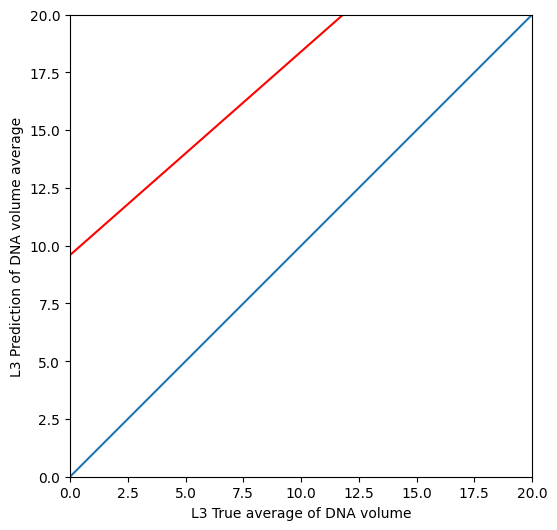

In [38]:
def randomforest_regressor(x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2,n_estimators=10)
    regr.fit(x_train, y_train)

    test_predictions = regr.predict(x_test).flatten()
    train_predictions = regr.predict(x_train).flatten()
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L3 True average of DNA volume')
    plt.ylabel('L3 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    with open('../saved_model/randomforest_model_L3.pkl', 'wb') as f:
        pickle.dump(regr, f)
randomforest_regressor(x_train, x_test, y_train, y_test)

In [ ]:
def voting_regressor(x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L3 True average of DNA volume')
    plt.ylabel('L3 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    #with open('../saved_model/randomforest_model_L3.pkl', 'wb') as f:
    #    pickle.dump(regr, f)
voting_regressor(x_train, x_test, y_train, y_test)

In [ ]:
def bagging_regressor(x_train,x_test,y_train,y_test):
    X = x_train
    y = y_train
    er = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=10),n_estimators=10)
    er = er.fit(X, y)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_train, train_predictions)
    plt.scatter(y_test, test_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L3 True average of DNA volume')
    plt.ylabel('L3 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,180])
    plt.ylim([0,180])
    _ = plt.plot([0,180], [0,180])

    plt.plot([0,180], res.intercept + res.slope*np.array([0, 180]), 'r', label='fitted line')

In [ ]:
bagging_regressor(x_train, x_test, y_train, y_test)